In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
current_path = Path().resolve()

## 1. Introduction

This project segments e-commerce customers based on their purchasing behavior using **RFM analysis** (Recency, Frequency, Monetary) and **K-Means clustering**, followed by the development of a **product recommendation system** tailored to each customer segment.

### 💡 Business Objectives

* Identify and retain **high-value customers** through personalized, high-quality product recommendations.
* Detect **churn-risk users** and re-engage them with affordable and popular products.
* Provide **relevant suggestions** to regular customers to encourage repeated purchases.
* Improve marketing ROI and **optimize customer lifetime value (CLV)**.

### 📊 Dataset Overview

* **Source**: [Kaggle - Ecommerce Transactions Dataset](https://www.kaggle.com/datasets/carrie1/ecommerce-data/data) 
* **Timeframe**: Transactions between **2010–2011**
* **Key Variables**:

  * `InvoiceNo`: Unique transaction ID
  * `StockCode`: Product identifier
  * `Description`: Product name
  * `Quantity`: Number of items purchased
  * `InvoiceDate`: Date of purchase
  * `UnitPrice`: Price per unit
  * `CustomerID`: Unique customer identifier
  * `Country`: Customer’s country

### 🧠 Project Flow

1. **RFM Feature Engineering**: Derive Recency, Frequency, and Monetary values for each customer.
2. **Customer Segmentation**: Apply K-Means clustering to group customers into behavioral segments.
3. **Product Similarity Modeling**:
   * Content-based similarity from product descriptions.
   * Co-purchase similarity based on historical baskets.
   * Combine both using a **hybrid similarity score**.
   
4. **Segment-Based Recommendation Strategy**:

   * Adjust hybrid score weights and boost rules according to customer cluster.
   * Recommend personalized products for each basket.

This approach combines **customer intelligence** and **product intelligence** to create a scalable, targeted recommendation system that supports both retention and revenue growth.


## 2. Data loading and cleaning

### 2.1 Load dataset

In [2]:
raw_data=pd.read_csv(f"{current_path}/ecommerce_data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
df=raw_data.copy()
df.shape

(541909, 8)

### 2.2 Data Cleaning & Preprocessing

Check missing values

In [3]:
# Check missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are 1454 null values in Description and 135080 null values in CustomerID

In [4]:
# Replace missing Description with 'No Description'
df.fillna({'Description': 'No Description'}, inplace=True)
df.fillna({'CustomerID': '-1'}, inplace=True)
# cast CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

Summary Statistics & Data Distribution

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,11476.725404
std,218.081158,96.759853,6778.330409
min,-80995.000000,-11062.060000,-1.000000
25%,1.000000,1.250000,12352.000000
50%,3.000000,2.080000,14382.000000
75%,10.000000,4.130000,16255.000000
max,80995.000000,38970.000000,18287.000000


We exclude negative quantity and unitPrice, and calculate the total sales

In [6]:
df=df[(df['UnitPrice']>0) & (df['Quantity']>0)]
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

Drop duplicated values

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(524878, 9)

Convert data types

In [8]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID       int64
Country         object
TotalSales     float64
dtype: object

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Add YearMonth, Hour, and Weekday

In [10]:
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")#.dt.to_timestamp()
df["Hour"] = df["InvoiceDate"].dt.hour
df["Weekday"] = df["InvoiceDate"].dt.dayofweek

## 3. Exploratory Data Analysis (EDA)

### 3.1 Identifer of product

As we can see below, the stockcode is not the unique identifier of the products, we need to use stockcode and description to concat a product name

In [11]:
df.groupby('StockCode')['Description'].nunique().reset_index().sort_values(by='Description', ascending=False).head(5)

,StockCode,Description
2089,23236,4
2049,23196,4
104,17107D,3
2203,23366,3
2056,23203,3


In [12]:
df.query('StockCode=="17107D"')['Description'].unique()

array(["FLOWER FAIRY,5 SUMMER B'DRAW LINERS",
       'FLOWER FAIRY 5 DRAWER LINERS',
       'FLOWER FAIRY 5 SUMMER DRAW LINERS'], dtype=object)

In [13]:
df["ProductName"] = df["StockCode"] + " - " + df["Description"]

### 3.2 Check the distribution of UnitPrice and Quantity

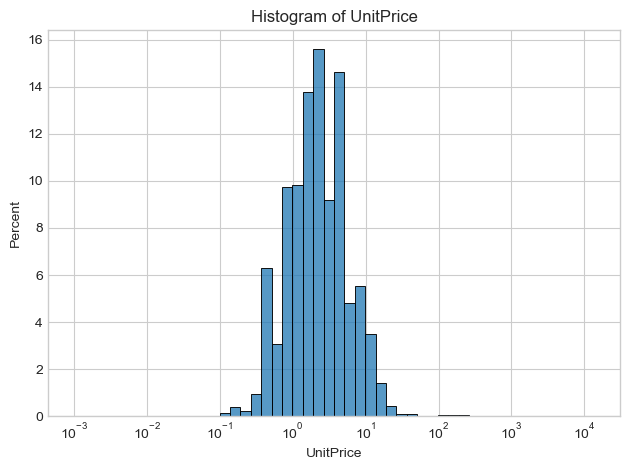

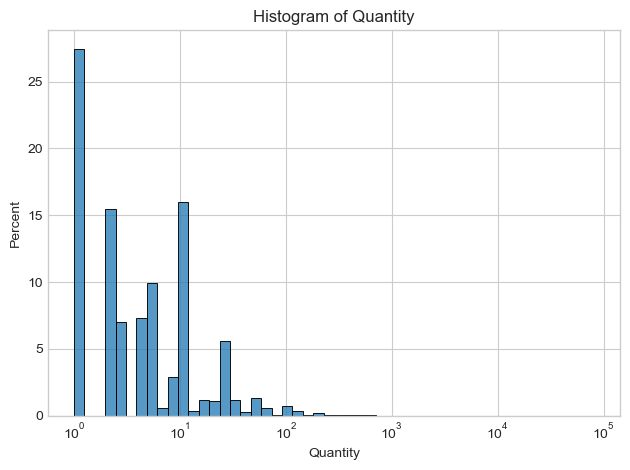

In [14]:
numerical_cols_to_plot = ['UnitPrice', 'Quantity']
for column in numerical_cols_to_plot:
    sns.histplot(data=df, x=column,log_scale=True, bins=50, stat='percent')
    plt.title(f'Histogram of {column}')
    
    plt.tight_layout()
    plt.show()

<Axes: xlabel='UnitPrice'>

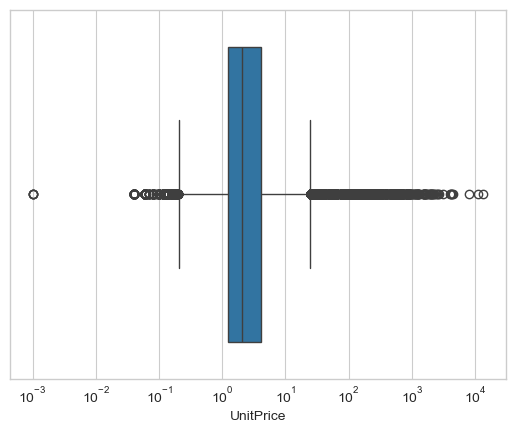

In [15]:
sns.boxplot(x=df["UnitPrice"],log_scale=True)

In [16]:
df['UnitPrice'].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

<Axes: xlabel='Quantity'>

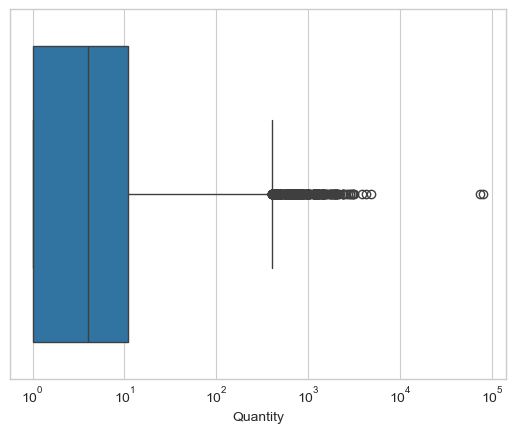

In [17]:
sns.boxplot(x=df["Quantity"],log_scale=True)

In [18]:
df['Quantity'].describe()

count    524878.000000
mean         10.616600
std         156.280031
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

Here we can see that majority of the UnitPrice is between 1-10, where the 25% - 75% quantile is 1.25-4.13, but the maximum could hit **13541**.<br>The same goes for quantity, the majority is between 1-10, but the maximum is 80995, we can see that some clients would order huge amount.


#### Check the volatility of UnitPrice

In [19]:
# Check the standard deviation of UnitPrice by ProductName, get the top 10
top_10_std = df.groupby('ProductName')['UnitPrice'].std().nlargest(10)
top_10_std

ProductName
AMAZONFEE - AMAZON FEE                   9419.772483
M - Manual                                654.055657
DOT - DOTCOM POSTAGE                      355.726548
POST - POSTAGE                            244.582494
22656 - VINTAGE BLUE KITCHEN CABINET       66.039761
22655 - VINTAGE RED KITCHEN CABINET        62.136568
22826 - LOVE SEAT ANTIQUE WHITE METAL      48.621234
22833 - HALL CABINET WITH 3 DRAWERS        25.435572
21769 - VINTAGE POST OFFICE CABINET        19.219162
23064 - CINDERELLA CHANDELIER              17.964517
Name: UnitPrice, dtype: float64

The product whose name starting from the letter are the gifts offered by the company to customers, we can see their unit price varies a lot.<br>While the variance of normal products are not that high.

### 3.3 Evolution of sales

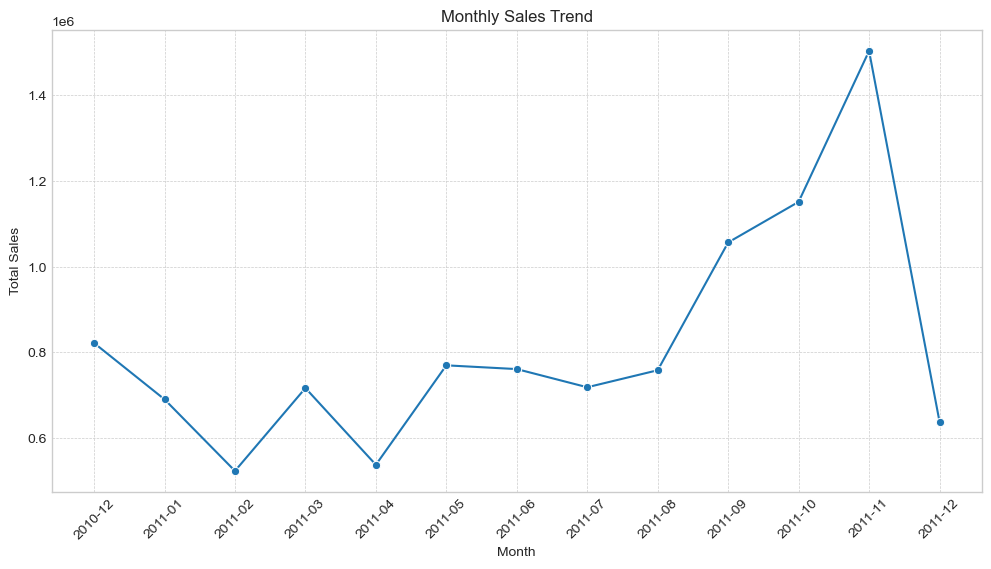

In [20]:
monthly_revenue = df.groupby("YearMonth")["TotalSales"].sum()

# Visualization: Monthly Revenue Trend
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_revenue.index.astype(str), y=monthly_revenue.values, marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

We can see that the sales is quite high in November, then we check what is driving sales in November

In [21]:
# For 2016 November, we get the top 10 products by sales
topN = 10
november_2016 = df[df["YearMonth"] == pd.Period("2011-11")]
november_top = november_2016.groupby("ProductName")["TotalSales"].sum().sort_values(ascending=False).index[:topN]
november_top

Index(['DOT - DOTCOM POSTAGE', '23084 - RABBIT NIGHT LIGHT',
       '22086 - PAPER CHAIN KIT 50'S CHRISTMAS ', '22197 - POPCORN HOLDER',
       '85123A - WHITE HANGING HEART T-LIGHT HOLDER',
       '22423 - REGENCY CAKESTAND 3 TIER',
       '22910 - PAPER CHAIN KIT VINTAGE CHRISTMAS',
       '23355 - HOT WATER BOTTLE KEEP CALM',
       '85099B - JUMBO BAG RED RETROSPOT', '79321 - CHILLI LIGHTS'],
      dtype='object', name='ProductName')

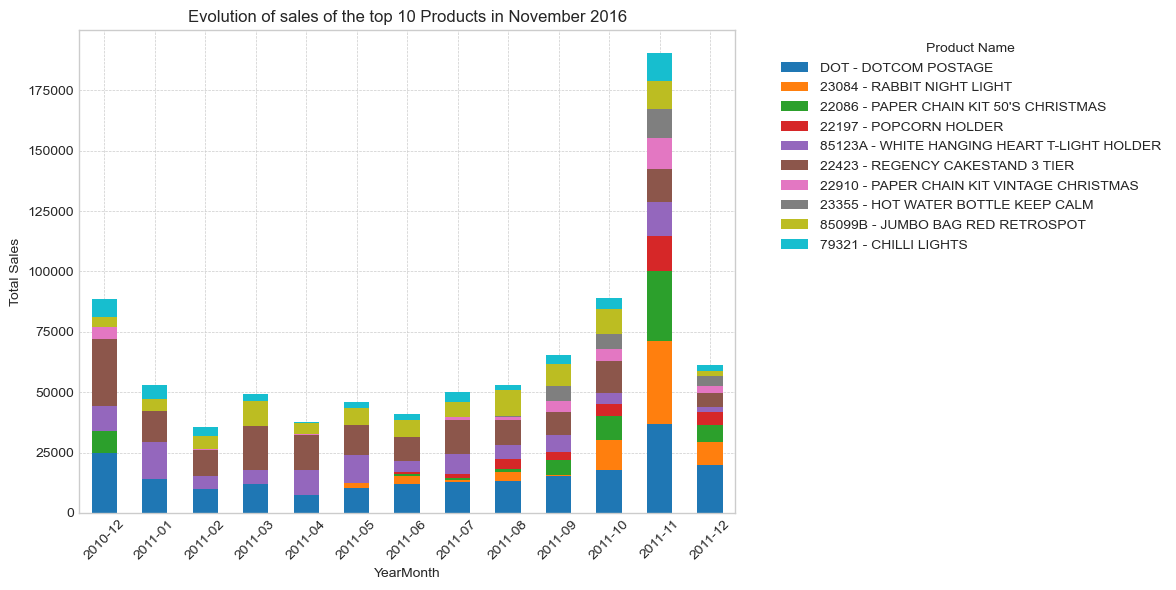

In [22]:
# Bar chart of the top 10 products by month, using stack plot
df_top = df[df["ProductName"].isin(november_top)]
df_top = df_top.groupby(["YearMonth", "ProductName"])["TotalSales"].sum().unstack()
df_top = df_top.fillna(0)

# sort the df_top by november_top
df_top = df_top[november_top]

df_top.plot(kind='bar', stacked=True, figsize=(12,6),)
plt.title(f"Evolution of sales of the top {topN} Products in November 2016")
plt.xlabel("YearMonth")
plt.ylabel("Total Sales")
plt.legend(title="Product Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


Holiday Gifts & Decorative Items were the main hot sellers in November.<br>
##### **📊 Trendy products**
- Dotcom postage (probably home decorations)
- Rabbit night light & PAPER CHAIN KIT & CHILLI LIGHTS (Christmas decorations and decorative lights)
- POPCRON HOLDER (probably film night/party related)
- HOT WATER BOTTLE KEEP CALM (winter warming items)

##### **✅ Executable Strategy**
🎯 Stock up ahead of time: Start increasing stock of Christmas decorations in September and test which products are popular.<br>
🎄 Limited edition products: Introduce specific styles, such as ‘limited edition Christmas night lights’, to increase appeal.

## 4. User cluster and RFM analysis

The **Recency, Frequency, Monetary (RFM) analysis** helps segment customers based on their purchasing behavior. This is crucial for:
- **Identifying loyal customers** who buy frequently.
- **Detecting inactive customers** who haven't purchased recently.
- **Understanding customer lifetime value (CLV)** to tailor marketing strategies.

🔵 **What Each RFM Metric Represents?**
- **Recency (R):** How recently a customer made a purchase (lower is better).
- **Frequency (F):** How often a customer purchases (higher is better).
- **Monetary (M):** Total amount a customer has spent (higher is better).

### 4.1 Calculate the RFM score

In [23]:
# We need to drop the unknown customers
df_user = df[df["CustomerID"] != -1]

In [24]:
# Define reference date (latest transaction date)
reference_date = df_user["InvoiceDate"].max()

# Compute Recency (Days Since Last Purchase), Frequency, and Monetary Value
rfm = df_user.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency
    "TotalSales": "sum"  # Monetary
})

# Rename columns
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.sort_values(by="Monetary", ascending=False, inplace=True)
# Display RFM table
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,91.536422,4.272015,2048.688081
std,100.014169,7.697998,8985.230220
min,0.000000,1.000000,3.750000
25%,17.000000,1.000000,306.482500
50%,50.000000,2.000000,668.570000
75%,141.000000,5.000000,1660.597500
max,373.000000,209.000000,280206.020000


💡 **Key Insights from RFM Scores**
- **High Recency (e.g., 373 days):** Many customers have been inactive for a long time → **Win-back campaigns needed.**
- **Low Frequency (e.g., median = 2):** Most customers **do not make frequent purchases** → **Loyalty programs & retention strategies required.**
- **Skewed Monetary Values (max = $280K, median = $668):** **A small group of VIP customers generates most revenue** → **High-value customer retention is critical.**

In [25]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
14646,1,73,280206.02
18102,0,60,259657.30
17450,7,46,194390.79
16446,0,2,168472.50
14911,0,201,143711.17


### 4.2 Customer Segmentation Using K-Means

Data Normalization

In [26]:
# Normalize the RFM values
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

df_rfm=pd.DataFrame(rfm_scaled, columns=["Recency", "Frequency", "Monetary"])

3D projection of the standardized RFM score

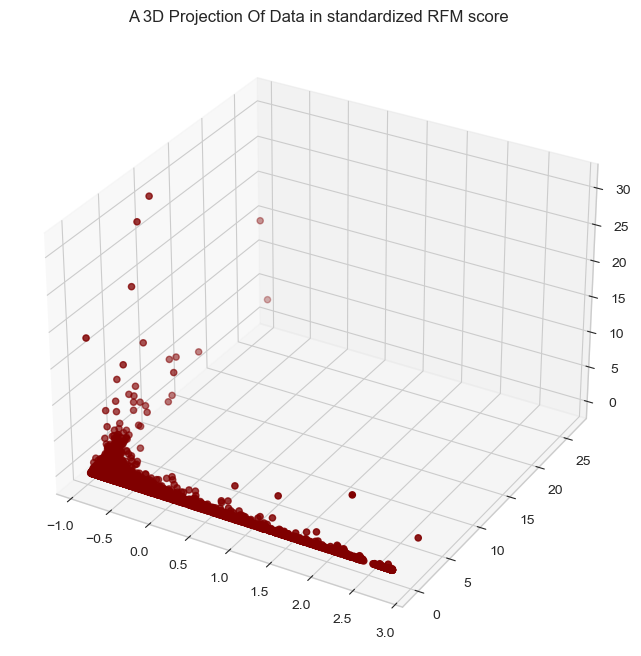

In [27]:
x=df_rfm["Recency"]
y=df_rfm["Frequency"]
z=df_rfm["Monetary"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data in standardized RFM score")
plt.show()

Use Elbow Method to determine best k

Elbow Method to determine the number of clusters to be formed:


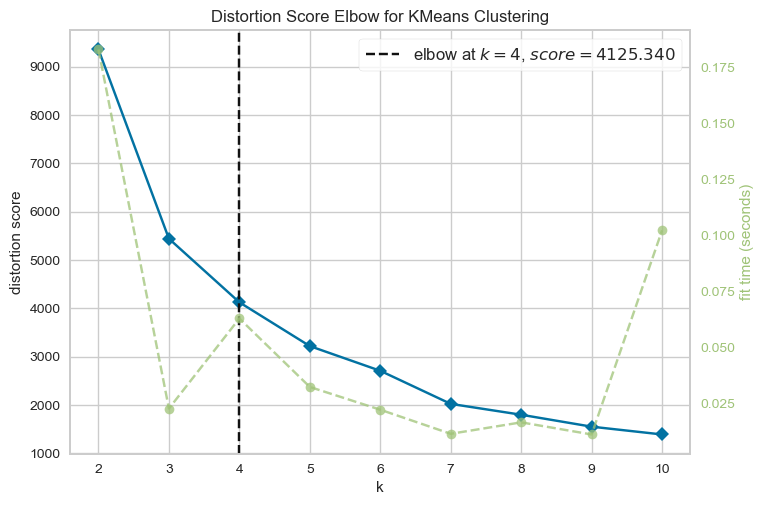

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
# !pip install yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_rfm)
Elbow_M.show()

Apply K-Means Clustering

In [29]:
#Initiating the Agglomerative Clustering model 
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(df_rfm)
df_rfm["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
rfm["Clusters"]=yhat_AC

In [30]:
rfm = rfm.reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Clusters
0,14646,1,73,280206.02,0
1,18102,0,60,259657.30,0
2,17450,7,46,194390.79,0
3,16446,0,2,168472.50,0
4,14911,0,201,143711.17,0


Visual presentation of different clusters

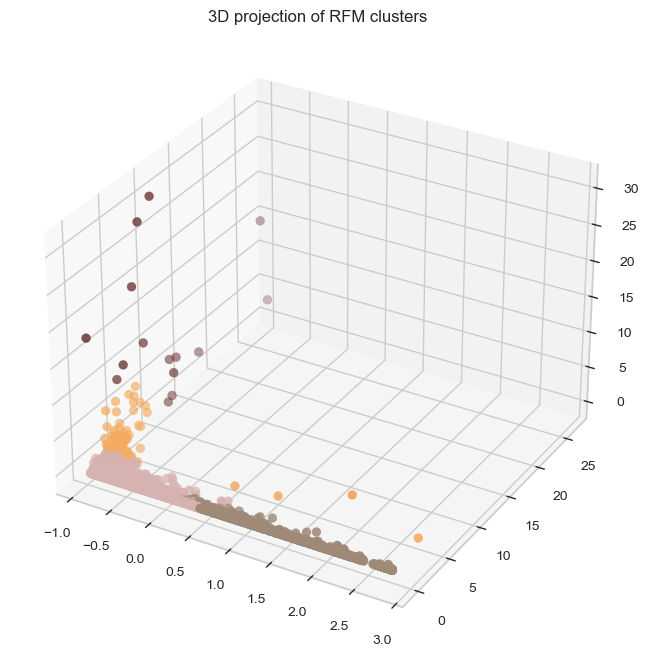

In [31]:
from matplotlib import colors
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=df_rfm["Clusters"], marker='o', cmap = cmap)
ax.set_title("3D projection of RFM clusters")
plt.show()

### 4.3 Naming Customer Segments Based on RFM Analysis

In [32]:
# Compute mean RFM values per cluster
rfm_avg = rfm.groupby("Clusters")[["Recency", "Frequency", "Monetary"]].mean().round(2)

# Display the average RFM values per segment
print("\n✅ Average RFM Values Per Segment:")
print(rfm_avg)


✅ Average RFM Values Per Segment:
          Recency  Frequency   Monetary
Clusters                               
0            5.73      83.47  111780.64
1           40.23       3.89    1479.41
2          240.41       1.64     518.62
3           13.63      24.44   14435.46


#### Interpreting the Customer Segments
Using these RFM values, we can now accurately define customer segments:

| **Segment Name** | **Cluster ID** | **Behavioral Characteristics** | **Marketing Strategy** |
|-----------------|--------------|-----------------------------|----------------|
| **VIP & High-Value Customers** | **Cluster 0** | **Very low Recency, extremely high Frequency, and highest Monetary value.** These are our most loyal and valuable customers. | ✅ **Offer exclusive rewards, loyalty programs, early access sales, and premium support to retain them.** |
| **Regular & Mid-Value Customers** | **Cluster 1** | **Moderate Recency, low Frequency, and moderate Monetary value.** These customers buy occasionally but aren’t fully engaged. | 📢 **Upsell & cross-sell strategies, seasonal promotions, and bundle offers to increase spending.** |
| **Churn-Risk Customers** | **Cluster 2** | **Very high Recency, very low Frequency, and low Monetary value.** These customers are at risk of churn and need re-engagement. | 🔥 **Win-back campaigns, reactivation discounts, and personalized email marketing to bring them back.** |
| **Frequent Mid-Value Buyers** | **Cluster 3** | **Low Recency, high Frequency, and medium-high Monetary value.** These customers shop frequently but spend less than VIPs. | 🎯 **Encourage larger purchases with bundling offers, loyalty incentives, and targeted promotions.** |

In [33]:
cluster_name_mapping={0:'VIP & High-Value Customers', 
                      1:'Regular & Mid-Value Customers',
                      2:'Churn-Risk Customers',  
                      3:'Frequent Mid-Value Buyers'}

In [34]:
rfm["ClusterName"] = rfm["Clusters"].map(cluster_name_mapping)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Clusters,ClusterName
0,14646,1,73,280206.02,0,VIP & High-Value Customers
1,18102,0,60,259657.30,0,VIP & High-Value Customers
2,17450,7,46,194390.79,0,VIP & High-Value Customers
3,16446,0,2,168472.50,0,VIP & High-Value Customers
4,14911,0,201,143711.17,0,VIP & High-Value Customers


#### ➡️ Extract Customer IDs for Each Segment

In [35]:
# Store customer IDs per segment
segment_dict = {}

for cluster in rfm["Clusters"].unique():
    segment_dict[f"Cluster_{cluster}"] = rfm[rfm["Clusters"] == cluster]["CustomerID"].tolist()

# Display first 10 customer IDs per segment
for cluster, customers in segment_dict.items():
    print(f"{cluster} - {len(customers)} Customers")
    print(customers[:10])
    print("...")

Cluster_0 - 15 Customers
[14646, 18102, 17450, 16446, 14911, 12415, 14156, 17511, 16029, 15311]
...
Cluster_3 - 147 Customers
[12346, 16684, 14096, 13694, 17949, 15769, 15061, 14298, 14088, 15749]
...
Cluster_1 - 3042 Customers
[12753, 12744, 12731, 12678, 14607, 14866, 12433, 12477, 14258, 12536]
...
Cluster_2 - 1134 Customers
[12590, 13093, 15032, 13802, 14016, 12755, 15379, 15808, 17230, 12643]
...


## 5. Product Recommendation Based on Customer Clusters

📦 In this recommendation system, we aim to deliver **personalized product suggestions** by leveraging both the **customer's historical purchase behavior** and **product similarity**. The approach is structured in several key steps:

### 🔍 1. Understand Product Similarity

We define **product-to-product similarity** in two complementary ways:

* **Content-based similarity**: Measures how similar two products are based on textual features such as name or category. This captures semantic or functional similarity (e.g., *"herb marker mint"* vs *"herb marker basil"*).

* **Co-purchase similarity**: Based on historical basket data, this measures how frequently two products are purchased together, capturing behavioral patterns (e.g., customers who bought *"teacup set"* also bought *"tea strainer"*).

By combining these two, we compute a **hybrid similarity score** using a weighted average:

$$
\text{HybridScore} = \alpha \cdot \text{ContentSim} + \beta \cdot \text{CoPurchaseSim}
$$

This hybrid score balances semantic meaning and user behavior.

### 🧺 2. Calculate Basket-Level Recommendation Scores

For a given basket (i.e., a list of products currently bought or browsed by a customer):

* Compute the **hybrid similarity** between each basket item and every other product.
* Aggregate these scores across the basket to generate a total score per candidate product.
* Products already in the basket are excluded from final recommendations.
* The top-N highest scoring products are returned as recommendations.


### 👥 3. Tailor Strategies by Customer Cluster

Based on **RFM segmentation**, each customer belongs to one of several behavioral clusters. Each segment uses **different weights (α, β)** when computing hybrid similarity, and applies price or popularity **boosting rules** in the final ranking to better match their behavior and motivation.


### 5.0 Preprocessing - Clean StockCode
We need to exclude the products that correspond to gifts offered by the company to customers, the products whose StockCode starts with letter, like DOT, AMAZON. After cleaning, we have 3900 SKUs

In [36]:
liste= df['StockCode'].unique() 
stock_to_del=[]
for el in liste:
    if el[0] not in ['1','2','3','4','5','6','7','8','9','10']: # products corresponding to gifts. 
        stock_to_del.append(el)

df_basket=df[df['StockCode'].map(lambda x: x not in stock_to_del)] 
df_basket=df_basket[['InvoiceNo','StockCode','CustomerID','Description']]
df_basket.drop_duplicates(inplace=True)
print(f'Totak SKUs: {df_basket["StockCode"].nunique()}')
df_basket.head()

Totak SKUs: 3900


,InvoiceNo,StockCode,CustomerID,Description
0,536365,85123A,17850,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,17850,WHITE METAL LANTERN
2,536365,84406B,17850,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,17850,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,17850,RED WOOLLY HOTTIE WHITE HEART.


In [37]:
all_baskets = df_basket.groupby(['InvoiceNo','CustomerID']).agg({'StockCode': lambda s: set(list(set(s)))}).reset_index().rename(columns={'StockCode':'Basket'})
all_baskets

,InvoiceNo,CustomerID,Basket
0,536365,17850,"{84029E, 71053, 21730, 84029G, 84406B, 22752, ..."
1,536366,17850,"{22633, 22632}"
2,536367,13047,"{21777, 22748, 21754, 21755, 22623, 48187, 223..."
3,536368,13047,"{22960, 22912, 22914, 22913}"
4,536369,13047,{21756}
...,...,...,...
19768,581583,13777,"{20725, 85038}"
19769,581584,13777,"{20832, 85038}"
19770,581585,15804,"{22727, 22466, 23328, 23084, 22460, 22915, 849..."
19771,581586,13113,"{21217, 22061, 20685, 23275}"


### 5.0 Preprocessing - Clean Description
Since there could be multiple descriptions linked to a StockCode, like 17107D have three descriptions: 
- `FLOWER FAIRY,5 SUMMER B'DRAW LINERS`
- `FLOWER FAIRY 5 DRAWER LINERS`
- `FLOWER FAIRY 5 SUMMER DRAW LINERS`

This could due to human typographical errors (e.g. ‘B'DRAW’ vs ‘DRAW’), or inconsistent marketing descriptions (e.g., adding ‘SUMMER’)or sub-category or packaging differences. We could select the most common one to replace the rest.

In [38]:
df_basket.query('StockCode=="17107D"')['Description'].unique()

array(["FLOWER FAIRY,5 SUMMER B'DRAW LINERS",
       'FLOWER FAIRY 5 DRAWER LINERS',
       'FLOWER FAIRY 5 SUMMER DRAW LINERS'], dtype=object)

In [39]:
product_df = df_basket[['StockCode','Description']].drop_duplicates().reset_index(drop=True)
product_df

desc_map = (
    df_basket.groupby(['StockCode', 'Description'])
    .size()
    .reset_index(name='count')
    .sort_values(['StockCode', 'count'], ascending=[True, False])
    .drop_duplicates('StockCode')
    .set_index('StockCode')['Description']
)

product_df['Unique_Description'] = product_df['StockCode'].map(desc_map)
product_df.head()

,StockCode,Description,Unique_Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,RED WOOLLY HOTTIE WHITE HEART.


Transform the description from raw text into a form more suitable for semantic analysis (e.g. TF-IDF): 
- unify the format
- remove the noise
- Lemmatization

In [40]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Function to clean product descriptions
def clean_description(desc):
    desc = str(desc).lower()
    desc = re.sub(r'[^a-zA-Z\s]', '', desc)
    tokens = desc.split()
    
    # Remove common English stopwords like "and", "the", "is"
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    # Lemmatize words to reduce them to their base or dictionary form
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

example = ['Set of 6 Christmas Tree Decorations - 3 Red and 3 Green', "FLOWER FAIRY,5 SUMMER B'DRAW LINERS"]
print(f'{example[0]} -> {clean_description(example[0])}\n{example[1]} -> {clean_description(example[1])}')

Set of 6 Christmas Tree Decorations - 3 Red and 3 Green -> set christmas tree decoration red green
FLOWER FAIRY,5 SUMMER B'DRAW LINERS -> flower fairy summer bdraw liner


In [41]:
# Run clean description on the Unique_Description column
product_df['Clean_Description'] = product_df['Unique_Description'].map(clean_description)
product_df.drop(columns=['Description','Unique_Description'], inplace=True)
product_df.drop_duplicates(inplace=True)
product_df

,StockCode,Clean_Description
0,85123A,white hanging heart tlight holder
1,71053,white metal lantern
2,84406B,cream cupid heart coat hanger
3,84029G,knitted union flag hot water bottle
4,84029E,red woolly hottie white heart
...,...,...
4133,85179a,green bitty light chain
4134,23617,set card swirly xmas tree
4135,90214U,letter u bling key ring
4136,47591b,scottie childrens apron


### 5.1 Compute Description Similarity
🔍 Description-based similarity helps recommend products that are semantically related, even if they haven’t been frequently bought together. For example, if a customer buys a “red polka dot mug,” the system might also recommend other mugs or kitchenware with similar descriptions like “blue striped mug” or “ceramic tea cup.” 

This is especially useful for **new products (cold start problem)** or for customers with sparse purchase history. It improves relevance by leveraging the text features of the products, providing a content-aware layer to complement co-purchase behavior.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel

descriptions = product_df[['StockCode','Clean_Description']].drop_duplicates().set_index('StockCode')

# 1. Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# 2. Fit and transform the cleaned descriptions
tfidf_matrix = vectorizer.fit_transform(descriptions['Clean_Description'])

# 3. Create a similarity matrix between products
content_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)  # cosine similarity
content_sim_df = pd.DataFrame(
    content_similarity,
    index=descriptions.index,
    columns=descriptions.index
)
content_sim_df.sort_index(ascending=True,axis=1,inplace=True)
content_sim_df.sort_index(ascending=True,axis=0,inplace=True)
content_sim_df.head(10)

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.333698,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10080,0.333698,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10123C,0.000000,0.000000,0.0,1.000000,0.287659,0.232074,0.314884,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10124A,0.000000,0.000000,0.0,0.287659,1.000000,0.548885,0.276211,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10124G,0.000000,0.000000,0.0,0.232074,0.548885,1.000000,0.222838,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10125,0.000000,0.000000,0.0,0.314884,0.276211,0.222838,1.000000,0.0,0.0,0.114337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10133,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10135,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
products_pair = [['10124G', '10124A'], ['11001', '10125']]
for product in products_pair:
    product1, product2 = product[0], product[1]
    sim = content_sim_df.loc[product1, product2]
    print(f'The similarity of description of\n- {product1}: {descriptions.loc[product1].values[0]}\n- {product2}: {descriptions.loc[product2].values[0]}\nare {sim}.\n')

The similarity of description of
- 10124G: army camo bookcover tape
- 10124A: spot red bookcover tape
are 0.5488849462173491.

The similarity of description of
- 11001: asstd design racing car pen
- 10125: mini funky design tape
are 0.11433692458928779.



#### Graphical presentation of content similarity

In [44]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_similarity_graph(product_id, sim_df, product_df=product_df, graph_name = '', top_n=5):
    """
    Visualize content-based similarity between a product and its top N similar products.

    Args:
        product_id (str): Product to analyze.
        content_sim_df (pd.DataFrame): TF-IDF-based content similarity matrix.
        product_df (pd.DataFrame): Includes 'StockCode' and 'Clean_Description'.
        top_n (int): Number of top similar products to show.
    """
    product_id = str(product_id)
    if product_id not in sim_df.index.astype(str):
        print(f"Product {product_id} not found in similarity matrix.")
        return

    # Get central product description
    desc_dict = product_df.set_index('StockCode')['Clean_Description'].astype(str).to_dict()
    center_desc = desc_dict.get(product_id, "(No description)")

    # Get top-N similar products
    sim_series = sim_df.loc[product_id].drop(product_id)
    top_similar = sim_series.sort_values(ascending=False).head(top_n)

    # Create graph
    G = nx.Graph()
    G.add_node(product_id, label=f"{product_id}\n{center_desc}")

    for pid, sim in top_similar.items():
        desc = desc_dict.get(pid, "(No desc)")
        G.add_node(pid, label=f"{pid}\n{desc}")
        G.add_edge(product_id, pid, weight=sim)

    # Layout and drawing
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))

    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, labels=labels, node_color='lightgreen', node_size=3000, font_size=8, font_weight='bold')

    edge_labels = {
        (u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"{graph_name} Similarity Graph for Product {product_id}", fontsize=14)
    plt.axis('off')
    plt.show()


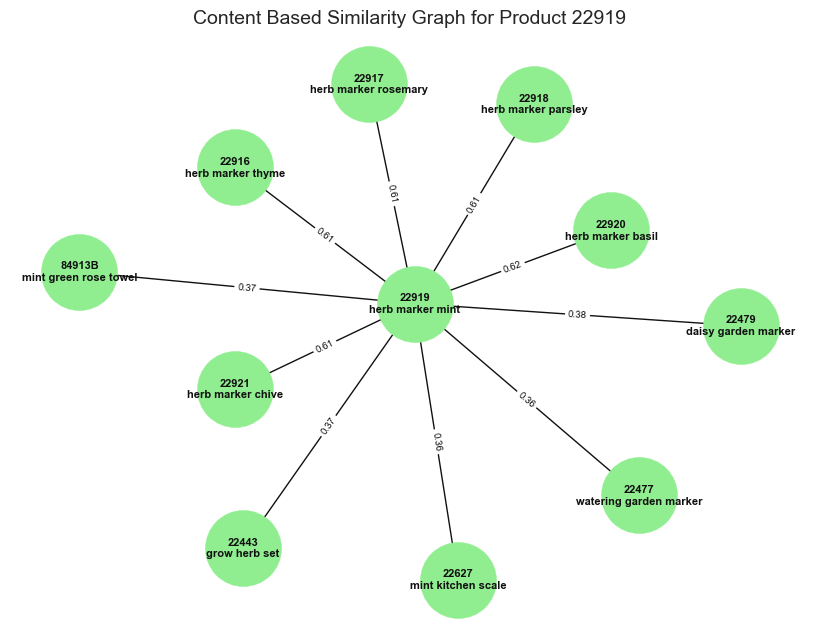

In [45]:
plot_similarity_graph(
    product_id='22919',
    sim_df=content_sim_df,
    graph_name='Content Based',
    top_n=10
)

### 5.1  Compute Co-purchase Similarity
🔍 Co-purchase similarity captures the relationship between products that are frequently bought together, based on historical transactions.

If many customers tend to purchase product A and product B in the same basket, it indicates a strong association between them — even if their textual descriptions are different.

This method reflects **real customer behavior and buying patterns**, making it highly effective for:
- Market basket-style recommendations
- Identifying complementary items (e.g., candle holders and candles)
- Adapting to emerging purchasing trends

Co-purchase similarity **complements content-based similarity** by learning from actual transactional data, rather than relying only on product features.

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Basket Matrix
basket = df_basket.drop_duplicates(subset=['InvoiceNo', 'StockCode'])
basket_matrix = pd.crosstab(basket['StockCode'], basket['InvoiceNo'])

# Compute cosine simularity
co_purchase_sim = cosine_similarity(basket_matrix)
co_purchase_sim_df = pd.DataFrame(co_purchase_sim, index=basket_matrix.index, columns=basket_matrix.index)

def recommend_by_copurchase(stockcode, top_n=5):
    if stockcode not in co_purchase_sim_df.index:
        return []
    sim_scores = co_purchase_sim_df[stockcode].sort_values(ascending=False)[1:top_n+1]
    return list(sim_scores.index)

co_purchase_sim_df

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.0,0.044076,0.068519,0.0,0.000000,0.062204,0.025431,0.107655,0.033493,...,0.053074,0.089009,0.071207,0.074138,0.035783,0.000000,0.000000,0.000000,0.041959,0.037529
10080,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.015229,0.000000,0.020056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10120,0.044076,0.0,1.000000,0.107211,0.0,0.000000,0.019466,0.013264,0.028074,0.017469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10123C,0.068519,0.0,0.107211,1.000000,0.0,0.000000,0.060523,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10124A,0.000000,0.0,0.000000,0.000000,1.0,0.447214,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90214U,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.447214,0.250000,0.200000,0.156174,0.301511,1.000000,0.267261,0.447214,0.353553,0.316228
90214V,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.028017,0.057270,0.020203,0.025142,...,0.119523,0.133631,0.160357,0.292174,0.241747,0.267261,1.000000,0.239046,0.283473,0.084515
90214W,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.046881,0.063888,0.033806,0.042070,...,0.200000,0.223607,0.268328,0.209529,0.134840,0.447214,0.239046,1.000000,0.316228,0.141421


#### Graphical presentation of co-purchase similarity

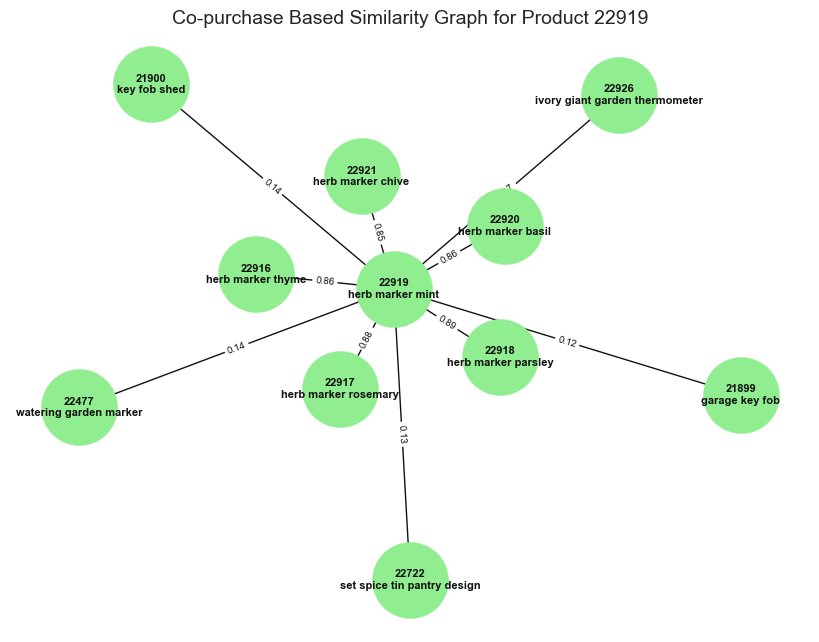

In [47]:
plot_similarity_graph(
    product_id='22919',
    sim_df=co_purchase_sim_df,
    graph_name='Co-purchase Based',
    top_n=10
)

### 5.2 Hybrid recommendation strategy
A hybrid approach combines content-based similarity (based on product descriptions) with co-purchase similarity (based on transaction history). This allows us to:
- Recommend items that are semantically similar even if they haven't been purchased together
- Reflect real customer behavior and frequently bought-together patterns

The weighted combination ensures a balanced recommendation system that is more robust to cold-start problems and better reflects both item properties and user preferences.

#### 🧮 Calculate Hybrid Score for a product

**For each product in the basket:**

   * Retrieve its content-based similarity scores with all other products (e.g. based on product descriptions).
   * Retrieve its co-purchase similarity scores with all other products (e.g. based on historical co-purchase behavior).
   * Combine the two using a weighted formula:

     $$
     \text{HybridScore}_{i \rightarrow j} = \alpha \cdot \text{ContentSim}_{i,j} + \beta \cdot \text{CoPurchaseSim}_{i,j}
     $$

     where $\alpha + \beta = 1$ (e.g. α = 0.5, β = 0.5).

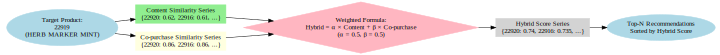

In [48]:
SVG(f"{current_path}/diagram/hybrid_score.svg")

#### 🧮 Calculate Hybrid Score for a Basket

   * Repeat the above step for each product in the basket.
   * **Sum up the hybrid similarity scores** across all basket items for each candidate product:

     $$
     \text{TotalHybridScore}_j = \sum_{i \in \text{Basket}} \text{HybridScore}_{i \rightarrow j}
     $$
   * This gives you a single score per candidate product, which reflects how well it matches the entire basket.


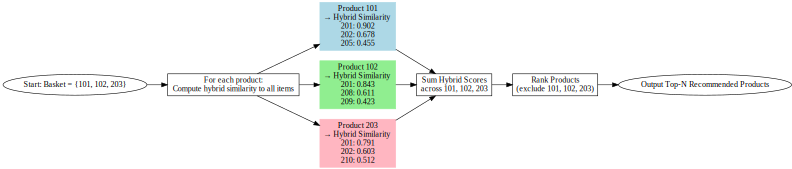

In [49]:
SVG(f"{current_path}/diagram/hybrid_score_of_basket.svg")

#### ❓ Why Use **Sum** Instead of **Average**?

Using the **sum** of hybrid scores across the basket reflects **cumulative evidence** of relevance. Here's why it's preferred over averaging:

* 🔁 **Longer baskets should have more weight**: If multiple items in the basket suggest the same product, summing gives it higher importance, as it appears repeatedly relevant.
* ⚖️ **Averaging would dilute strong signals** from one or two items in a larger basket.
* 💡 Summing naturally boosts products that are **similar to many basket items**, which is exactly the goal of basket-based recommendation.

> In short: **sum captures total affinity**, while average could underestimate a product that's highly relevant to multiple items.

In [96]:
def hybrid_recommend_from_basket(
    basket,
    content_sim_df = content_sim_df,
    co_purchase_sim_df = co_purchase_sim_df,
    weight_content=0.5,
    weight_co_purchase=0.5,
    top_n=5,
):
    """
    Hybrid recommendation based on both content and co-purchase similarity.

    Parameters:
        basket (list of str): List of StockCodes the user has in their basket.
        content_sim_df (pd.DataFrame): Content-based similarity matrix.
        co_purchase_sim_df (pd.DataFrame): Co-purchase similarity matrix.
        weight_content (float): Weight for content similarity (default 0.5).
        weight_co_purchase (float): Weight for co-purchase similarity (default 0.5).
        top_n (int): Number of products to recommend.
        exclude_in_basket (bool): Whether to exclude items already in the basket.

    Returns:
        pd.DataFrame: Top N recommended products with hybrid similarity scores.
    """

    valid_basket = [p for p in basket if p in content_sim_df.columns or p in co_purchase_sim_df.columns]

    if not valid_basket:
        return pd.Series(dtype=float)

    # Content similarity matrix slice
    content_part = (
        content_sim_df[valid_basket]
        .fillna(0)
        .mul(weight_content)
        if valid_basket else pd.DataFrame()
    )

    # Co-purchase similarity matrix slice
    co_part = (
        co_purchase_sim_df[valid_basket]
        .fillna(0)
        .mul(weight_co_purchase)
        if valid_basket else pd.DataFrame()
    )

    # Add two parts (handling if one is empty)
    combined_df = content_part.add(co_part, fill_value=0)

    # Sum similarity scores across all basket products
    scores = combined_df.sum(axis=1)

    # Drop already purchased products
    scores = scores.drop(labels=basket, errors="ignore")

    return scores.sort_values(ascending=False).head(top_n)


In [97]:
example_basket = ['22919', '22921', '22916']
hybrid_recommend_from_basket(example_basket)

StockCode
22917    2.200492
22918    2.198181
22920    2.166091
22477    0.722277
22479    0.698728
dtype: float64

#### Get products recommendation for all baskets

In [65]:
all_baskets

,InvoiceNo,CustomerID,Basket
0,536365,17850,"{84029E, 71053, 21730, 84029G, 84406B, 22752, ..."
1,536366,17850,"{22633, 22632}"
2,536367,13047,"{21777, 22748, 21754, 21755, 22623, 48187, 223..."
3,536368,13047,"{22960, 22912, 22914, 22913}"
4,536369,13047,{21756}
...,...,...,...
19768,581583,13777,"{20725, 85038}"
19769,581584,13777,"{20832, 85038}"
19770,581585,15804,"{22727, 22466, 23328, 23084, 22460, 22915, 849..."
19771,581586,13113,"{21217, 22061, 20685, 23275}"


In [100]:
from joblib import Parallel, delayed

def process_row(row):
    recom_series = hybrid_recommend_from_basket(row.Basket)
    return {
        'InvoiceNo': row.InvoiceNo,
        'CustomerID': row.CustomerID,
        'Basket': row.Basket,
        'RecommendProduct': recom_series.index.tolist(),
        'HybridScore': [round(score, 2) for score in recom_series.values]
    }

results = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_row)(row) for row in all_baskets.itertuples(index=False)
)

df_with_recom = pd.DataFrame(results)
df_with_recom


,InvoiceNo,CustomerID,Basket,RecommendProduct,HybridScore
0,536365,17850,"{84029E, 71053, 21730, 84029G, 84406B, 22752, ...","[21733, 85123a, 21313, 84970S, 21479]","[1.19, 1.1, 1.0, 0.98, 0.94]"
1,536366,17850,"{22633, 22632}","[23439, 22865, 22867, 22866, 22834]","[1.05, 0.99, 0.97, 0.91, 0.78]"
2,536367,13047,"{21777, 22748, 21754, 21755, 22623, 48187, 223...","[22746, 21756, 22747, 22666, 22750]","[1.65, 1.65, 1.56, 1.1, 1.02]"
3,536368,13047,"{22960, 22912, 22914, 22913}","[22788, 22467, 23411, 22719, 22961]","[0.88, 0.86, 0.78, 0.65, 0.64]"
4,536369,13047,{21756},"[21754, 21755, 22120, 82583, 22623]","[0.56, 0.53, 0.22, 0.19, 0.17]"
...,...,...,...,...,...
19768,581583,13777,"{20725, 85038}","[22384, 20727, 20726, 22383, 22382]","[0.54, 0.53, 0.53, 0.5, 0.5]"
19769,581584,13777,"{20832, 85038}","[22134, 70006, 22862, 22132, 22135]","[0.47, 0.46, 0.45, 0.45, 0.43]"
19770,581585,15804,"{22727, 22466, 23328, 23084, 22460, 22915, 849...","[84032A, 22728, 84031A, 21313, 84970S]","[2.18, 2.15, 2.04, 2.02, 2.0]"
19771,581586,13113,"{21217, 22061, 20685, 23275}","[21843, 22055, 22840, 20676, 37449]","[0.93, 0.76, 0.7, 0.67, 0.65]"


### 5.3 🎯 How to Adapt Product Recommendation by Customer Segment

| Cluster        | Behavior Profile                            | Strategy                                                         |
| -------------- | ------------------------------------------- | ---------------------------------------------------------------- |
| **VIP**        | High frequency & spending, very loyal       | Recommend high-value, cross-category products; emphasize quality |
| **Churn-risk** | Inactive recently, low frequency & spending | Recommend popular, low-cost products; use reactivation offers    |
| **Mid-value**  | Moderate frequency & value                  | Balanced strategy; mix of popular and related products           |

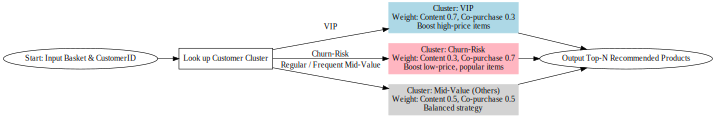

In [53]:
SVG(f"{current_path}/diagram/cluster_strategy.svg")

#### Useful dataframes

In [54]:
product_price_df = df.groupby('StockCode').agg({'TotalSales': 'sum', 'Quantity': 'sum'}).reset_index()
product_price_df['AvgPrice'] = product_price_df['TotalSales'] / product_price_df['Quantity']
product_price_df = product_price_df[product_price_df['StockCode'].map(lambda x: x not in stock_to_del)].set_index('StockCode')
product_price_df

,TotalSales,Quantity,AvgPrice
StockCode,,,
10002,759.89,860,0.883593
10080,119.09,303,0.393036
10120,40.32,192,0.210000
10123C,3.25,5,0.650000
10124A,6.72,16,0.420000
...,...,...,...
90214U,3.48,12,0.290000
90214V,15.98,26,0.614615
90214W,6.82,16,0.426250


In [55]:
rfm_cluster_df = rfm[['CustomerID','Clusters','ClusterName']]
rfm_cluster_df.set_index('CustomerID', inplace=True)
rfm_cluster_df.head()

,Clusters,ClusterName
CustomerID,,
14646,0,VIP & High-Value Customers
18102,0,VIP & High-Value Customers
17450,0,VIP & High-Value Customers
16446,0,VIP & High-Value Customers
14911,0,VIP & High-Value Customers


#### Build ProductRecommenderByCluster Object

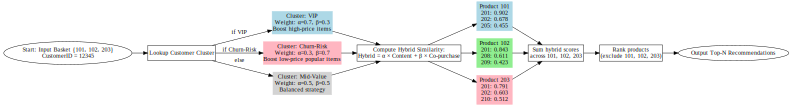

In [56]:
SVG(f"{current_path}/diagram/whole_process.svg")

In [57]:
class ProductRecommenderByCluster:

    def __init__(self, content_sim_df, co_purchase_sim_df, product_price_df, rfm_cluster_df):
        """
        Initialize the recommender with similarity matrices and product metadata.
        """
        self.content_sim_df = content_sim_df
        self.co_purchase_sim_df = co_purchase_sim_df
        self.product_price_df = product_price_df  # Contains TotalSales, Quantity, AvgPrice
        self.rfm_cluster_df = rfm_cluster_df


    def get_customer_segment(self, customer_id):
        """
        Retrieve customer cluster name.
        """
        if customer_id in self.rfm_cluster_df.index:
            return self.rfm_cluster_df.loc[customer_id, 'ClusterName']
        else:
            return "Unknown"


    def recommend(self, basket, customer_id=None, top_n=5):
        """
        Recommend top N products for a given basket of products and customer.
        """
        # Default weights
        weight_content = 0.5
        weight_co_purchase = 0.5
        segment = self.get_customer_segment(customer_id)

        # Adjust strategy based on segment
        if segment == "VIP & High-Value Customers":
            weight_content = 0.7
            weight_co_purchase = 0.3
        elif segment == "Churn-Risk Customers":
            weight_content = 0.3
            weight_co_purchase = 0.7

        scores = pd.Series(dtype=float)

        for product in basket:
            # Content similarity
            if product in self.content_sim_df.index:
                content_scores = self.content_sim_df[product]
            else:
                content_scores = pd.Series(0, index=self.content_sim_df.index)

            # Co-purchase similarity
            if product in self.co_purchase_sim_df.index:
                co_scores = self.co_purchase_sim_df[product]
            else:
                co_scores = pd.Series(0, index=self.co_purchase_sim_df.index)

            # Weighted score
            combined_scores = weight_content * content_scores + weight_co_purchase * co_scores
            scores = scores.add(combined_scores, fill_value=0)

        # Remove already purchased products
        scores = scores.drop(labels=basket, errors='ignore')

        # Enhance scoring based on customer segment
        if segment == "VIP & High-Value Customers":
            # Boost higher-priced products
            price_weight = self.product_price_df['AvgPrice'].rank(pct=True)
            scores = scores.multiply(1 + 0.2 * price_weight, fill_value=1)
        elif segment == "Churn-Risk Customers":
            # Boost popular, low-priced products
            sales_weight = self.product_price_df['Quantity'].rank(pct=True)
            price_weight = 1 - self.product_price_df['AvgPrice'].rank(pct=True)
            scores = scores.multiply((1 + 0.1 * sales_weight) * (1 + 0.2 * price_weight), fill_value=1)

        # Final top-N recommendations
        recommended_products = scores.sort_values(ascending=False).head(top_n)
        
        return recommended_products
    
    def recommend_from_basket(self, basket_df, top_n=5, n_jobs=5):
        """
        Recommend top N products for a batch of baskets.
        """
        if 'Basket' not in basket_df.columns:
            raise ValueError("Input DataFrame must contain 'Basket' column.")

        contain_customer_id = 'CustomerID' in basket_df.columns

        def process_row(index, row):
            try:
                basket = row['Basket']
                customer_id = row['CustomerID'] if contain_customer_id else None
                recommendations = self.recommend(basket, customer_id, top_n)
                return index, recommendations.index.tolist(), [round(v, 3) for v in recommendations.values.tolist()]
            except Exception as e:
                print(f"Error processing row {index}: {e}")
                return index, [], []

        # Run in parallel
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_row)(index, row) for index, row in basket_df.iterrows()
        )

        basket_df['Recommendations'] = None
        basket_df['Scores'] = None
        for index, recs, scores in results:
            basket_df.at[index, 'Recommendations'] = recs
            basket_df.at[index, 'Scores'] = scores

        return basket_df
    
recommender = ProductRecommenderByCluster(content_sim_df, co_purchase_sim_df, product_price_df, rfm_cluster_df)

The object can return the top N products based on basket and customer id

In [58]:
basket = ['22632', '22633', '22727']
customer_id = 17850

recommender.recommend(basket, customer_id)

StockCode
23439    1.138206
22865    1.044757
22867    1.023689
22866    0.950902
22726    0.831618
dtype: float64

For unknown product, it will return 0 as score

In [59]:
recommender.recommend(['Z0'], top_n=3)

StockCode
10002     0.0
46000R    0.0
37491A    0.0
dtype: float64

#### Recommend products for different customer clusters

In [60]:
vip_customer_basket = all_baskets[all_baskets['CustomerID'].isin(rfm_cluster_df.query('ClusterName=="VIP & High-Value Customers"').index)]
vip_customer_basket = vip_customer_basket.sort_values(by=['CustomerID','InvoiceNo'], ascending=True).reset_index(drop=True)
vip_customer_basket

,InvoiceNo,CustomerID,Basket
0,540267,12415,"{20675, 22505, 84228, 21243, 22379, 20676, 226..."
1,540557,12415,{22523}
2,543989,12415,"{84997B, 22842, 22329, 22505, 22840, 22843, 22..."
3,545475,12415,"{22699, 22029, 21240, 22274, 22619, 22273, 215..."
4,553546,12415,"{23172, 22918, 22466, 84519B, 22699, 22488, 21..."
...,...,...,...
1234,574383,18102,"{23404, 23133, 82484, 22188}"
1235,579139,18102,{85152}
1236,581455,18102,"{23404, 22188, 82484, 23542, 23133, 22189, 235..."
1237,581457,18102,"{22188, 82484, 23542, 23526, 22189, 23530, 235..."


In [61]:
recommender.recommend_from_basket(vip_customer_basket, top_n=5)

,InvoiceNo,CustomerID,Basket,Recommendations,Scores
0,540267,12415,"{20675, 22505, 84228, 21243, 22379, 20676, 226...","[22523, 22861, 22520, 22521, 15058A]","[5.133, 4.978, 4.806, 4.61, 4.561]"
1,540557,12415,{22523},"[22523, 22522, 22521, 22515, 22517]","[1.041, 0.871, 0.609, 0.571, 0.555]"
2,543989,12415,"{84997B, 22842, 22329, 22505, 22840, 22843, 22...","[22720, 20725, 23245, 23307, 22352]","[9.341, 8.226, 7.317, 7.093, 6.995]"
3,545475,12415,"{22699, 22029, 21240, 22274, 22619, 22273, 215...","[22720, 20725, 23245, 22348, 20914]","[8.12, 7.888, 6.91, 6.63, 6.455]"
4,553546,12415,"{23172, 22918, 22466, 84519B, 22699, 22488, 21...","[23245, 84032A, 21094, 84031A, 22423]","[5.557, 4.955, 4.737, 4.71, 4.626]"
...,...,...,...,...,...
1234,574383,18102,"{23404, 23133, 82484, 22188}","[23133, 82484, 23404, 22188, 23132]","[1.177, 1.172, 1.158, 1.121, 0.959]"
1235,579139,18102,{85152},"[85152, 21908, 85049G, 22632, 85049g]","[1.097, 0.495, 0.3, 0.298, 0.295]"
1236,581455,18102,"{23404, 22188, 82484, 23542, 23133, 22189, 235...","[23538, 23132, 23134, 23528, 23533]","[2.442, 2.424, 2.404, 1.87, 1.829]"
1237,581457,18102,"{22188, 82484, 23542, 23526, 22189, 23530, 235...","[23538, 23528, 23533, 23537, 23541]","[3.024, 2.679, 2.679, 2.514, 2.465]"


In [62]:
churn_customer_basket = all_baskets[all_baskets['CustomerID'].isin(rfm_cluster_df.query('ClusterName=="Churn-Risk Customers"').index)]
churn_customer_basket = churn_customer_basket.sort_values(by=['CustomerID','InvoiceNo'], ascending=True).reset_index(drop=True)
churn_customer_basket

,InvoiceNo,CustomerID,Basket
0,543037,12350,"{22348, 21908, 20615, 21866, 21832, 79191C, 22..."
1,553900,12353,"{37449, 22890, 37446, 37450}"
2,550911,12354,"{20675, 21243, 20676, 21156, 21080, 23255, 223..."
3,552449,12355,"{72802A, 23076, 72802B, 23077, 22699, 85040A, ..."
4,545017,12361,"{22629, 22328, 20726, 22631, 22555, 22326, 226..."
...,...,...,...
1840,557431,18260,"{23118, 23048, 22082, 22189, 23245, 22697, 475..."
1841,561010,18262,"{23293, 21400, 23295, 22433, 23309, 20971, 214..."
1842,537817,18269,"{21731, 22837, 22418, 22451, 22450, 22449, 22617}"
1843,545712,18280,"{22611, 22727, 22495, 22358, 82484, 22084, 227..."


In [63]:
recommender.recommend_from_basket(churn_customer_basket, top_n=5)

,InvoiceNo,CustomerID,Basket,Recommendations,Scores
0,543037,12350,"{22348, 21908, 20615, 21866, 21832, 79191C, 22...","[82580, 22819, 22553, 22279, 21935]","[2.27, 2.117, 2.089, 2.081, 2.079]"
1,553900,12353,"{37449, 22890, 37446, 37450}","[22055, 37446, 37450, 37449, 37447]","[1.3, 1.207, 1.132, 1.069, 1.063]"
2,550911,12354,"{20675, 21243, 20676, 21156, 21080, 23255, 223...","[20724, 21212, 22356, 85099B, 20719]","[9.29, 8.235, 8.189, 8.15, 7.494]"
3,552449,12355,"{72802A, 23076, 72802B, 23077, 22699, 85040A, ...","[23170, 23171, 23172, 23173, 72803A]","[1.947, 1.878, 1.842, 1.795, 1.751]"
4,545017,12361,"{22629, 22328, 20726, 22631, 22555, 22326, 226...","[22662, 22384, 20727, 22383, 20728]","[2.84, 2.79, 2.788, 2.786, 2.746]"
...,...,...,...,...,...
1840,557431,18260,"{23118, 23048, 22082, 22189, 23245, 22697, 475...","[22699, 22457, 22698, 85123A, 22961]","[2.973, 2.755, 2.693, 2.682, 2.601]"
1841,561010,18262,"{23293, 21400, 23295, 22433, 23309, 20971, 214...","[21212, 23307, 23294, 84991, 21975]","[2.738, 2.611, 2.496, 2.494, 2.438]"
1842,537817,18269,"{21731, 22837, 22418, 22451, 22450, 22449, 22617}","[22418, 21731, 22754, 22617, 22449]","[1.272, 1.22, 1.135, 1.126, 1.12]"
1843,545712,18280,"{22611, 22727, 22495, 22358, 82484, 22084, 227...","[22726, 22728, 22730, 22729, 22467]","[1.909, 1.817, 1.614, 1.49, 1.191]"
